<a href="https://colab.research.google.com/github/cmaguire001/Brazilian_Ecommerce_Analysis/blob/main/Machine_utilization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required package
!pip install striprtf

# -------------------------------
# Imports
# -------------------------------
import re
import sqlite3
from striprtf.striprtf import rtf_to_text
from datetime import datetime, timedelta
import hashlib

# -------------------------------
# Configuration
# -------------------------------
RTF_FILE = "machine log events 1.rtf"   # Your uploaded RTF file
DB_FILE = "machine_logs.db"                     # Output database file
ANON_SALT = "internal_confidential_salt_2025"

# -------------------------------
# Helper functions
# -------------------------------
def seconds_since_start(ts, start_ts):
    return (ts - start_ts).total_seconds()

def anonymize_machine_id(machine_id: str) -> str:
    h = hashlib.sha256((machine_id + ANON_SALT).encode()).hexdigest()
    return f"M-{h[:10]}"

# -------------------------------
# Step 1: Load RTF and clean text
# -------------------------------
with open(RTF_FILE, "r", encoding="utf-8") as file:
    rtf_content = file.read()

plain_text = rtf_to_text(rtf_content)

# -------------------------------
# Step 2: Parse events
# -------------------------------
# Example: (12/15 07:11:54) Start Processing
event_pattern = re.compile(
    r"\((\d{2}/\d{2}) (\d{2}:\d{2}:\d{2})\)\s*(Start Processing|Processing End!)"
)

events = []
for match in event_pattern.finditer(plain_text):
    date_str, time_str, event_type = match.groups()
    # Assign a fixed year for anonymization
    timestamp = datetime.strptime(f"2025-{date_str} {time_str}", "%Y-%m/%d %H:%M:%S")
    events.append({"timestamp": timestamp, "event": event_type})

if not events:
    raise ValueError("No events found in the log. Check RTF parsing.")

# -------------------------------
# Step 3: Generate runs
# -------------------------------
runs = []
anchor_time = events[0]["timestamp"]  # Reference for anonymization

for i in range(0, len(events), 2):
    try:
        start_event = events[i]
        end_event = events[i + 1]
        if start_event["event"] == "Start Processing" and end_event["event"] == "Processing End!":
            run_duration = (end_event["timestamp"] - start_event["timestamp"]).total_seconds()
            runs.append({
                "anon_batch_id": f"A{(i//2)+1:03d}",
                "start_offset_sec": seconds_since_start(start_event["timestamp"], anchor_time),
                "end_offset_sec": seconds_since_start(end_event["timestamp"], anchor_time),
                "duration_seconds": run_duration,
                "status": "ACTIVE"
            })
    except IndexError:
        pass  # Ignore incomplete runs

# -------------------------------
# Step 4: Insert idle periods
# -------------------------------
full_day_start = anchor_time.replace(hour=0, minute=0, second=0)
full_day_end = anchor_time.replace(hour=23, minute=59, second=59)

# Idle before first run
if runs[0]["start_offset_sec"] > 0:
    runs.insert(0, {
        "anon_batch_id": "IDLE",
        "start_offset_sec": 0,
        "end_offset_sec": runs[0]["start_offset_sec"],
        "duration_seconds": runs[0]["start_offset_sec"],
        "status": "IDLE"
    })

# Idle between runs
i = 1
while i < len(runs):
    prev_end = runs[i-1]["end_offset_sec"]
    curr_start = runs[i]["start_offset_sec"]
    gap = curr_start - prev_end
    if gap > 1:
        runs.insert(i, {
            "anon_batch_id": "IDLE",
            "start_offset_sec": prev_end,
            "end_offset_sec": curr_start,
            "duration_seconds": gap,
            "status": "IDLE"
        })
        i += 1
    i += 1

# -------------------------------
# Step 5: Save to SQLite
# -------------------------------
conn = sqlite3.connect(DB_FILE)
c = conn.cursor()

c.execute("""
CREATE TABLE IF NOT EXISTS runs (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    anon_batch_id TEXT,
    start_offset_sec REAL,
    end_offset_sec REAL,
    duration_seconds REAL,
    status TEXT
)
""")

for run in runs:
    c.execute("""
    INSERT INTO runs (anon_batch_id, start_offset_sec, end_offset_sec, duration_seconds, status)
    VALUES (?, ?, ?, ?, ?)
    """, (run["anon_batch_id"], run["start_offset_sec"], run["end_offset_sec"], run["duration_seconds"], run["status"]))

conn.commit()
conn.close()

print(f"Machine log anonymized and saved to {DB_FILE} ✅")


Machine log anonymized and saved to machine_logs.db ✅


In [ ]:
import sqlite3
import pandas as pd

# Connect to the database
DB_FILE = "machine_logs.db"
conn = sqlite3.connect(DB_FILE)

# Load entire runs table into a DataFrame
df = pd.read_sql_query("SELECT * FROM runs", conn)

conn.close()

# Show the first few rows
print("First 10 rows:")
print(df.head(10))

# Quick summary
total_active_time = df[df['status']=='ACTIVE']['duration_seconds'].sum()
total_idle_time = df[df['status']=='IDLE']['duration_seconds'].sum()
num_runs = df[df['status']=='ACTIVE'].shape[0]

print("\nSummary:")
print(f"Number of ACTIVE runs: {num_runs}")
print(f"Total ACTIVE time (seconds): {total_active_time}")
print(f"Total IDLE time (seconds): {total_idle_time}")

# Optional: show all rows sorted by start_offset_sec
print("\nAll rows sorted by start_offset_sec:")
print(df.sort_values('start_offset_sec').reset_index(drop=True))


First 10 rows:
   id anon_batch_id  start_offset_sec  end_offset_sec  duration_seconds  \
0   1          A001               0.0          1047.0            1047.0   
1   2          IDLE            1047.0          1447.0             400.0   
2   3          A002            1447.0          2495.0            1048.0   
3   4          IDLE            2495.0          3775.0            1280.0   
4   5          A003            3775.0          4818.0            1043.0   
5   6          IDLE            4818.0          5147.0             329.0   
6   7          A004            5147.0          6196.0            1049.0   
7   8          IDLE            6196.0          7002.0             806.0   
8   9          A005            7002.0          8057.0            1055.0   
9  10          IDLE            8057.0          8568.0             511.0   

   status  
0  ACTIVE  
1    IDLE  
2  ACTIVE  
3    IDLE  
4  ACTIVE  
5    IDLE  
6  ACTIVE  
7    IDLE  
8  ACTIVE  
9    IDLE  

Summary:
Number of ACTIVE 

Number of ACTIVE runs: 20
Total ACTIVE time: 348.70 minutes
Total IDLE time: 222.47 minutes
Average run duration: 17.43 minutes
Longest IDLE gap: 21.33 minutes


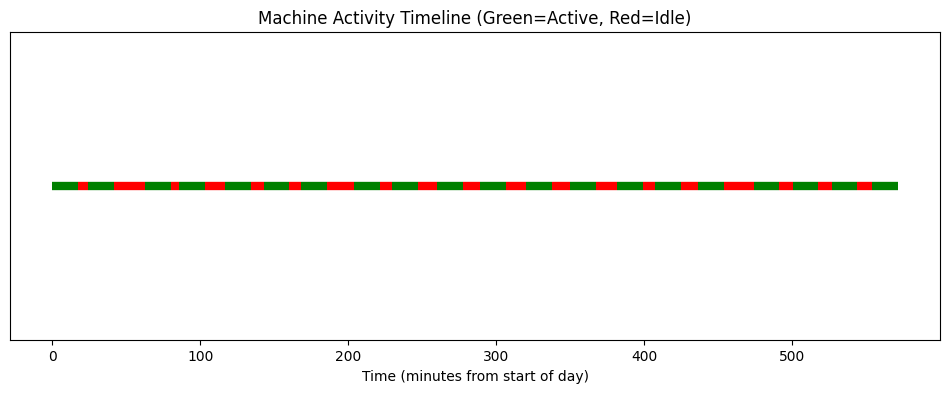

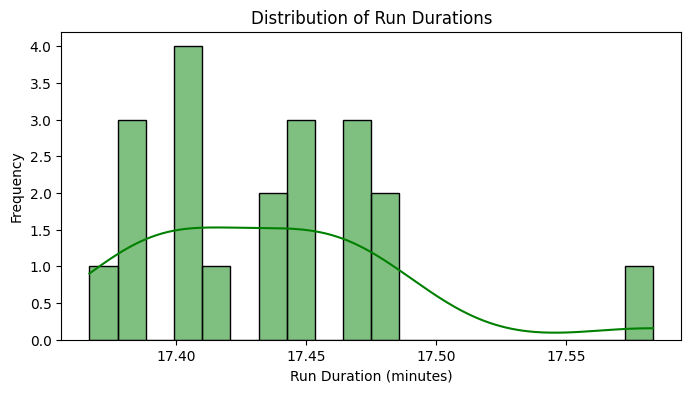

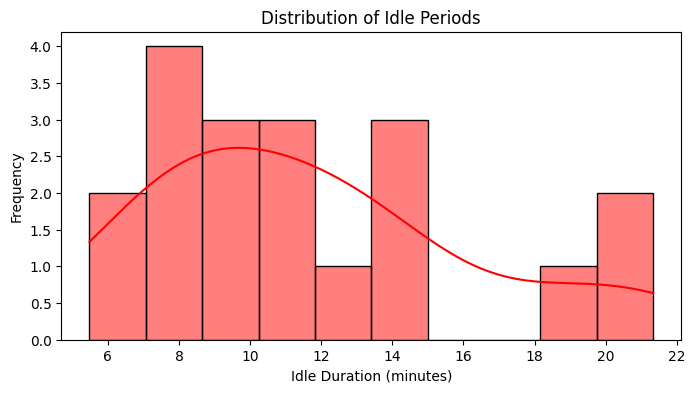

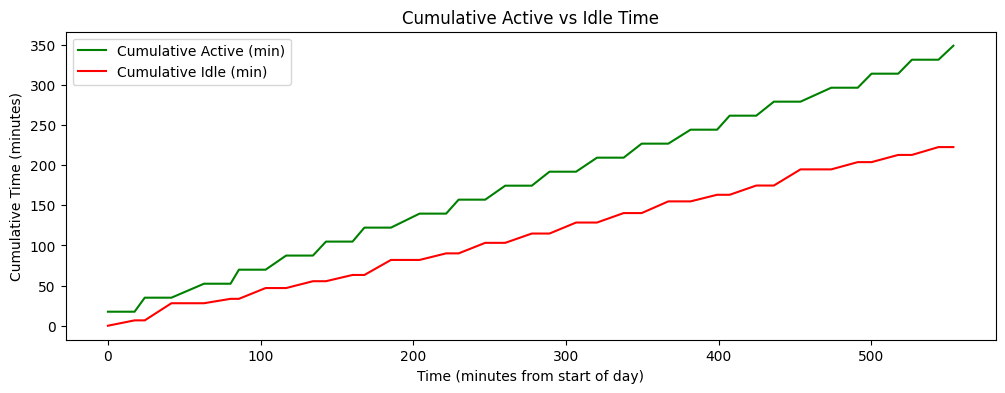

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Step 1: Load the database
# -------------------------------
DB_FILE = "machine_logs.db"
conn = sqlite3.connect(DB_FILE)
df = pd.read_sql_query("SELECT * FROM runs", conn)
conn.close()

# Convert offsets to timedelta for easier plotting
df['start_offset_td'] = pd.to_timedelta(df['start_offset_sec'], unit='s')
df['end_offset_td'] = pd.to_timedelta(df['end_offset_sec'], unit='s')

# -------------------------------
# Step 2: Basic insights
# -------------------------------
num_runs = df[df['status']=='ACTIVE'].shape[0]
total_active_time = df[df['status']=='ACTIVE']['duration_seconds'].sum()
total_idle_time = df[df['status']=='IDLE']['duration_seconds'].sum()
avg_run_duration = df[df['status']=='ACTIVE']['duration_seconds'].mean()
max_idle_gap = df[df['status']=='IDLE']['duration_seconds'].max()

print(f"Number of ACTIVE runs: {num_runs}")
print(f"Total ACTIVE time: {total_active_time/60:.2f} minutes")
print(f"Total IDLE time: {total_idle_time/60:.2f} minutes")
print(f"Average run duration: {avg_run_duration/60:.2f} minutes")
print(f"Longest IDLE gap: {max_idle_gap/60:.2f} minutes")

# -------------------------------
# Step 3: Plot Active vs Idle timeline
# -------------------------------
plt.figure(figsize=(12,4))
for _, row in df.iterrows():
    color = 'green' if row['status']=='ACTIVE' else 'red'
    plt.hlines(1, row['start_offset_sec']/60, row['end_offset_sec']/60, colors=color, linewidth=6)

plt.xlabel('Time (minutes from start of day)')
plt.yticks([])
plt.title('Machine Activity Timeline (Green=Active, Red=Idle)')
plt.show()

# -------------------------------
# Step 4: Distribution of run durations
# -------------------------------
plt.figure(figsize=(8,4))
sns.histplot(df[df['status']=='ACTIVE']['duration_seconds']/60, bins=20, kde=True, color='green')
plt.xlabel('Run Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Run Durations')
plt.show()

# -------------------------------
# Step 5: Idle gap analysis
# -------------------------------
idle_gaps = df[df['status']=='IDLE']['duration_seconds']/60
plt.figure(figsize=(8,4))
sns.histplot(idle_gaps, bins=10, color='red', kde=True)
plt.xlabel('Idle Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Idle Periods')
plt.show()

# -------------------------------
# Step 6: Cumulative utilization
# -------------------------------
df['cumulative_active_sec'] = df.apply(lambda r: r['duration_seconds'] if r['status']=='ACTIVE' else 0, axis=1).cumsum()
df['cumulative_idle_sec'] = df.apply(lambda r: r['duration_seconds'] if r['status']=='IDLE' else 0, axis=1).cumsum()

plt.figure(figsize=(12,4))
plt.plot(df['start_offset_sec']/60, df['cumulative_active_sec']/60, label='Cumulative Active (min)', color='green')
plt.plot(df['start_offset_sec']/60, df['cumulative_idle_sec']/60, label='Cumulative Idle (min)', color='red')
plt.xlabel('Time (minutes from start of day)')
plt.ylabel('Cumulative Time (minutes)')
plt.title('Cumulative Active vs Idle Time')
plt.legend()
plt.show()


Machine Utilization: 61.05%
Average Run Duration: 17.43 minutes
Threshold Short: 15.69 min | Threshold Long: 19.18 min

Batch Summary:
   anon_batch_id  run_count  avg_duration_sec  min_duration_sec  \
0           A001          1            1047.0            1047.0   
1           A002          1            1048.0            1048.0   
2           A003          1            1043.0            1043.0   
3           A004          1            1049.0            1049.0   
4           A005          1            1055.0            1055.0   
5           A006          1            1044.0            1044.0   
6           A007          1            1044.0            1044.0   
7           A008          1            1046.0            1046.0   
8           A009          1            1044.0            1044.0   
9           A010          1            1044.0            1044.0   
10          A011          1            1045.0            1045.0   
11          A012          1            1048.0            1048

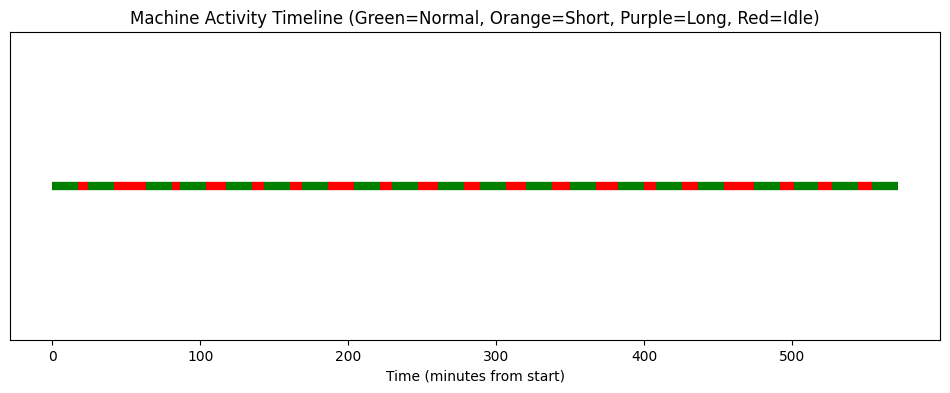

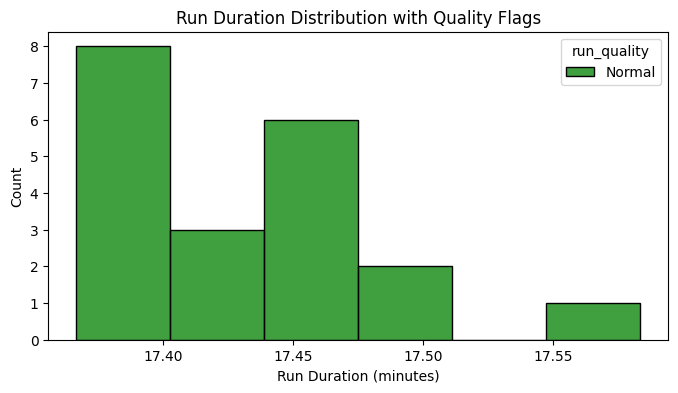

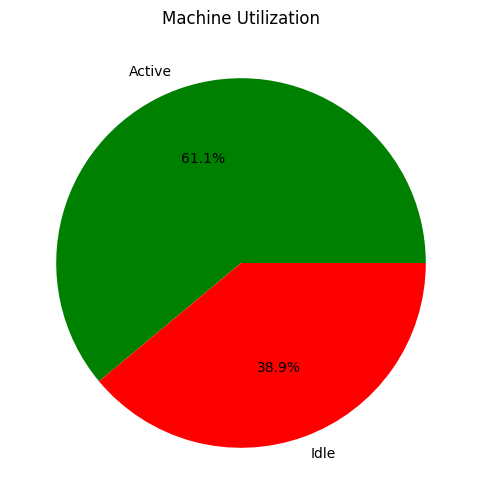

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# -------------------------------
# Step 1: Load the database
# -------------------------------
DB_FILE = "machine_logs.db"
conn = sqlite3.connect(DB_FILE)
df = pd.read_sql_query("SELECT * FROM runs", conn)
conn.close()

# -------------------------------
# Step 2: Compute key metrics
# -------------------------------
total_active_time = df[df['status']=='ACTIVE']['duration_seconds'].sum()
total_idle_time = df[df['status']=='IDLE']['duration_seconds'].sum()
machine_utilization = total_active_time / (total_active_time + total_idle_time) * 100

avg_run_duration = df[df['status']=='ACTIVE']['duration_seconds'].mean()

# Identify unusually short/long runs (±10% deviation)
threshold_short = avg_run_duration * 0.9
threshold_long = avg_run_duration * 1.1
df['run_quality'] = None
df.loc[(df['status']=='ACTIVE') & (df['duration_seconds'] < threshold_short), 'run_quality'] = 'Short'
df.loc[(df['status']=='ACTIVE') & (df['duration_seconds'] > threshold_long), 'run_quality'] = 'Long'
df.loc[(df['status']=='ACTIVE') & (df['duration_seconds'] >= threshold_short) & (df['duration_seconds'] <= threshold_long), 'run_quality'] = 'Normal'

print(f"Machine Utilization: {machine_utilization:.2f}%")
print(f"Average Run Duration: {avg_run_duration/60:.2f} minutes")
print(f"Threshold Short: {threshold_short/60:.2f} min | Threshold Long: {threshold_long/60:.2f} min")

# -------------------------------
# Step 3: Batch-level summary
# -------------------------------
batch_summary = df[df['status']=='ACTIVE'].groupby('anon_batch_id').agg(
    run_count=('anon_batch_id','count'),
    avg_duration_sec=('duration_seconds','mean'),
    min_duration_sec=('duration_seconds','min'),
    max_duration_sec=('duration_seconds','max')
).reset_index()

batch_summary['avg_duration_min'] = batch_summary['avg_duration_sec']/60
batch_summary['min_duration_min'] = batch_summary['min_duration_sec']/60
batch_summary['max_duration_min'] = batch_summary['max_duration_sec']/60

print("\nBatch Summary:")
print(batch_summary)

# -------------------------------
# Step 4: Visualization
# -------------------------------
# 1️⃣ Timeline highlighting short/long runs
plt.figure(figsize=(12,4))
for _, row in df.iterrows():
    if row['status']=='ACTIVE':
        color = {'Short':'orange','Long':'purple','Normal':'green'}[row['run_quality']]
    else:
        color = 'red'
    plt.hlines(1, row['start_offset_sec']/60, row['end_offset_sec']/60, colors=color, linewidth=6)

plt.xlabel('Time (minutes from start)')
plt.yticks([])
plt.title('Machine Activity Timeline (Green=Normal, Orange=Short, Purple=Long, Red=Idle)')
plt.show()

# 2️⃣ Histogram of run durations with quality labels
plt.figure(figsize=(8,4))
sns.histplot(df[df['status']=='ACTIVE'], x=df['duration_seconds']/60, hue='run_quality', multiple='stack', palette={'Normal':'green','Short':'orange','Long':'purple'})
plt.xlabel('Run Duration (minutes)')
plt.ylabel('Count')
plt.title('Run Duration Distribution with Quality Flags')
plt.show()

# 3️⃣ Pie chart of machine utilization
plt.figure(figsize=(6,6))
plt.pie([total_active_time, total_idle_time], labels=['Active','Idle'], colors=['green','red'], autopct='%1.1f%%')
plt.title('Machine Utilization')
plt.show()


In [ ]:
import pandas as pd
import sqlite3

# Load DB
DB_FILE = "machine_logs.db"
conn = sqlite3.connect(DB_FILE)
df = pd.read_sql_query("SELECT * FROM runs", conn)
conn.close()

# Keep only idle periods
idle_df = df[df['status']=='IDLE'].copy()

# Average idle duration
avg_idle_sec = idle_df['duration_seconds'].mean()
max_idle_sec = idle_df['duration_seconds'].max()
min_idle_sec = idle_df['duration_seconds'].min()

print(f"Average idle time between runs: {avg_idle_sec/60:.2f} minutes")
print(f"Max idle time: {max_idle_sec/60:.2f} minutes")
print(f"Min idle time: {min_idle_sec/60:.2f} minutes")


Average idle time between runs: 11.71 minutes
Max idle time: 21.33 minutes
Min idle time: 5.48 minutes


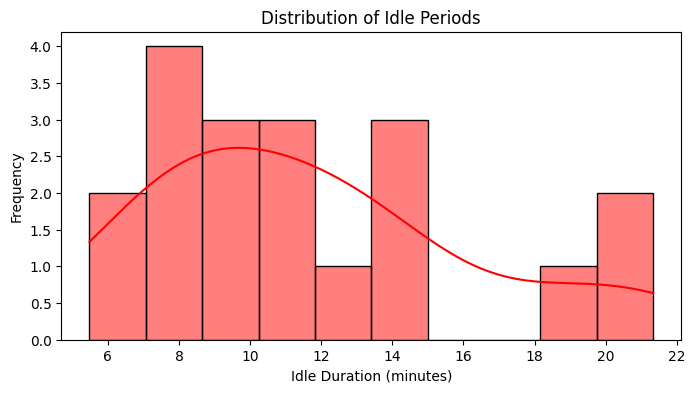

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



# 2️⃣ Histogram of idle durations
plt.figure(figsize=(8,4))
sns.histplot(idle_df['duration_seconds']/60, bins=10, kde=True, color='red')
plt.xlabel('Idle Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Idle Periods')
plt.show()

=== Key Metrics ===
Number of ACTIVE runs: 20
Average Run Duration: 17.43 min
Average Idle Time Between Runs: 11.71 min
Machine Utilization: 61.05%


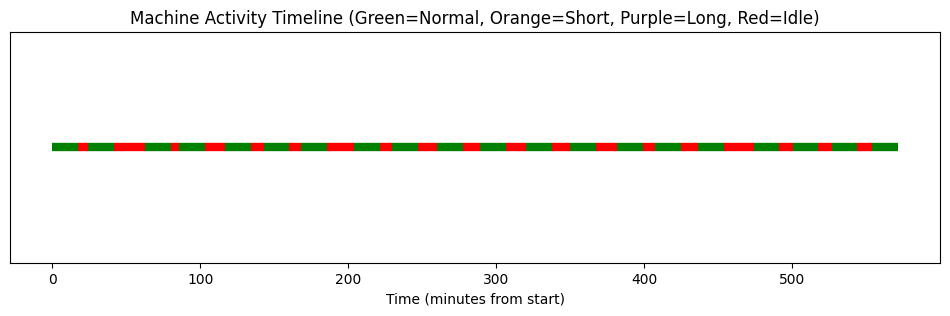

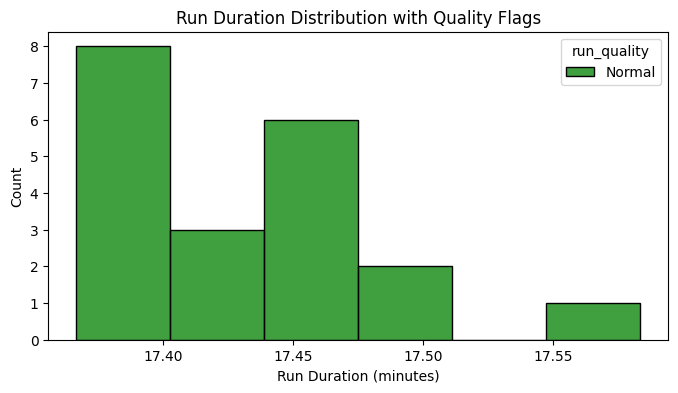

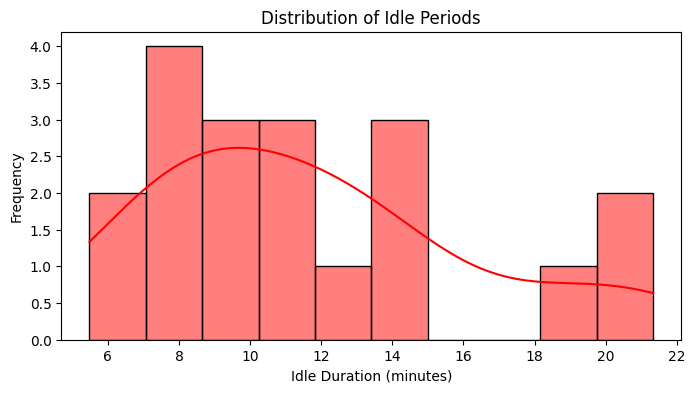

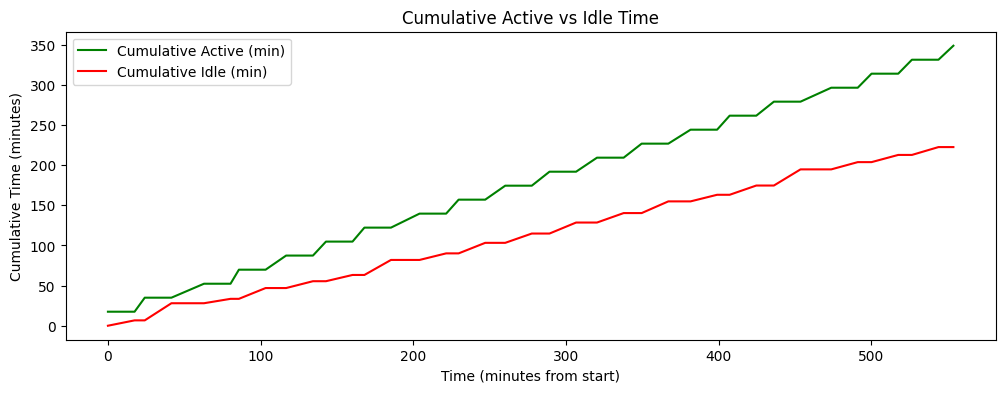

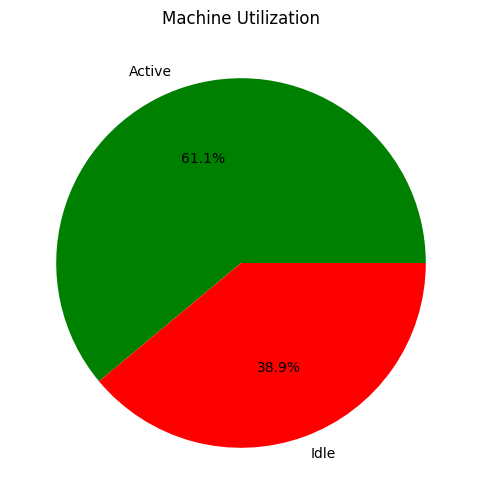


=== Batch Summary ===
   anon_batch_id  run_count  avg_duration_min  min_duration_min  \
0           A001          1         17.450000         17.450000   
1           A002          1         17.466667         17.466667   
2           A003          1         17.383333         17.383333   
3           A004          1         17.483333         17.483333   
4           A005          1         17.583333         17.583333   
5           A006          1         17.400000         17.400000   
6           A007          1         17.400000         17.400000   
7           A008          1         17.433333         17.433333   
8           A009          1         17.400000         17.400000   
9           A010          1         17.400000         17.400000   
10          A011          1         17.416667         17.416667   
11          A012          1         17.466667         17.466667   
12          A013          1         17.466667         17.466667   
13          A014          1         17.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# -------------------------------
# Step 1: Load the database
# -------------------------------
DB_FILE = "machine_logs.db"
conn = sqlite3.connect(DB_FILE)
df = pd.read_sql_query("SELECT * FROM runs", conn)
conn.close()

# -------------------------------
# Step 2: Add run quality flags
# -------------------------------
avg_run_duration = df[df['status']=='ACTIVE']['duration_seconds'].mean()
threshold_short = avg_run_duration * 0.9
threshold_long = avg_run_duration * 1.1
df['run_quality'] = None
df.loc[(df['status']=='ACTIVE') & (df['duration_seconds'] < threshold_short), 'run_quality'] = 'Short'
df.loc[(df['status']=='ACTIVE') & (df['duration_seconds'] > threshold_long), 'run_quality'] = 'Long'
df.loc[(df['status']=='ACTIVE') & (df['duration_seconds'] >= threshold_short) & (df['duration_seconds'] <= threshold_long), 'run_quality'] = 'Normal'

# -------------------------------
# Step 3: Compute key metrics
# -------------------------------
total_active_time = df[df['status']=='ACTIVE']['duration_seconds'].sum()
total_idle_time = df[df['status']=='IDLE']['duration_seconds'].sum()
machine_utilization = total_active_time / (total_active_time + total_idle_time) * 100
num_runs = df[df['status']=='ACTIVE'].shape[0]
avg_idle_time = df[df['status']=='IDLE']['duration_seconds'].mean()

print("=== Key Metrics ===")
print(f"Number of ACTIVE runs: {num_runs}")
print(f"Average Run Duration: {avg_run_duration/60:.2f} min")
print(f"Average Idle Time Between Runs: {avg_idle_time/60:.2f} min")
print(f"Machine Utilization: {machine_utilization:.2f}%")

# -------------------------------
# Step 4: Timeline of machine activity
# -------------------------------
plt.figure(figsize=(12,3))
for _, row in df.iterrows():
    if row['status']=='ACTIVE':
        color = {'Normal':'green','Short':'orange','Long':'purple'}[row['run_quality']]
    else:
        color = 'red'
    plt.hlines(1, row['start_offset_sec']/60, row['end_offset_sec']/60, colors=color, linewidth=6)

plt.xlabel('Time (minutes from start)')
plt.yticks([])
plt.title('Machine Activity Timeline (Green=Normal, Orange=Short, Purple=Long, Red=Idle)')
plt.show()

# -------------------------------
# Step 5: Histogram of run durations
# -------------------------------
plt.figure(figsize=(8,4))
sns.histplot(df[df['status']=='ACTIVE'], x=df['duration_seconds']/60, hue='run_quality', multiple='stack',
             palette={'Normal':'green','Short':'orange','Long':'purple'})
plt.xlabel('Run Duration (minutes)')
plt.ylabel('Count')
plt.title('Run Duration Distribution with Quality Flags')
plt.show()

# -------------------------------
# Step 6: Histogram of idle durations
# -------------------------------
idle_df = df[df['status']=='IDLE']
plt.figure(figsize=(8,4))
sns.histplot(idle_df['duration_seconds']/60, bins=10, kde=True, color='red')
plt.xlabel('Idle Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Idle Periods')
plt.show()

# -------------------------------
# Step 7: Cumulative active vs idle
# -------------------------------
df['cumulative_active_sec'] = df.apply(lambda r: r['duration_seconds'] if r['status']=='ACTIVE' else 0, axis=1).cumsum()
df['cumulative_idle_sec'] = df.apply(lambda r: r['duration_seconds'] if r['status']=='IDLE' else 0, axis=1).cumsum()

plt.figure(figsize=(12,4))
plt.plot(df['start_offset_sec']/60, df['cumulative_active_sec']/60, label='Cumulative Active (min)', color='green')
plt.plot(df['start_offset_sec']/60, df['cumulative_idle_sec']/60, label='Cumulative Idle (min)', color='red')
plt.xlabel('Time (minutes from start)')
plt.ylabel('Cumulative Time (minutes)')
plt.title('Cumulative Active vs Idle Time')
plt.legend()
plt.show()

# -------------------------------
# Step 8: Pie chart of utilization
# -------------------------------
plt.figure(figsize=(6,6))
plt.pie([total_active_time, total_idle_time], labels=['Active','Idle'], colors=['green','red'], autopct='%1.1f%%')
plt.title('Machine Utilization')
plt.show()

# -------------------------------
# Step 9: Optional table of batches
# -------------------------------
batch_summary = df[df['status']=='ACTIVE'].groupby('anon_batch_id').agg(
    run_count=('anon_batch_id','count'),
    avg_duration_sec=('duration_seconds','mean'),
    min_duration_sec=('duration_seconds','min'),
    max_duration_sec=('duration_seconds','max')
).reset_index()

batch_summary['avg_duration_min'] = batch_summary['avg_duration_sec']/60
batch_summary['min_duration_min'] = batch_summary['min_duration_sec']/60
batch_summary['max_duration_min'] = batch_summary['max_duration_sec']/60

print("\n=== Batch Summary ===")
print(batch_summary[['anon_batch_id','run_count','avg_duration_min','min_duration_min','max_duration_min']])


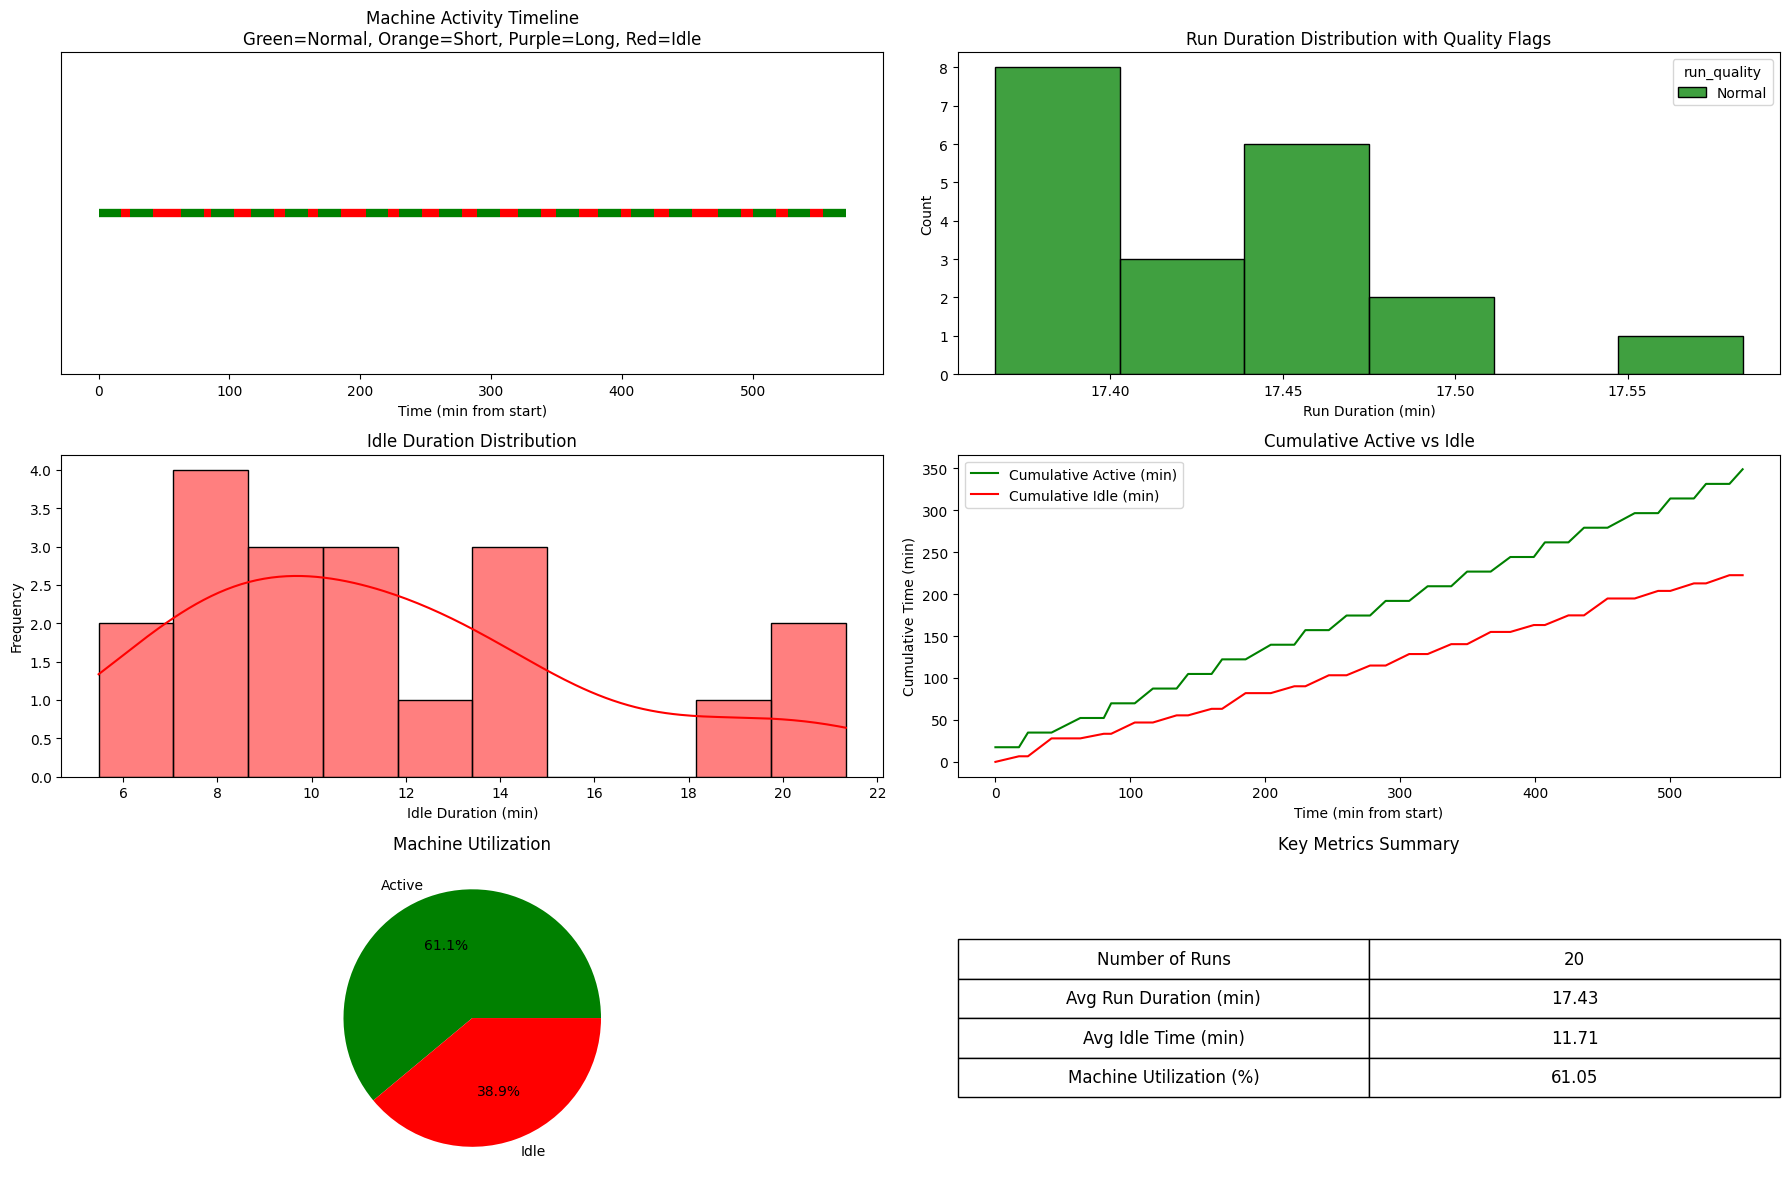

Storyboard PDF saved: Machine_Storyboard_Dashboard.pdf


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from matplotlib.gridspec import GridSpec

# -------------------------------
# Step 1: Load the database
# -------------------------------
DB_FILE = "machine_logs.db"
conn = sqlite3.connect(DB_FILE)
df = pd.read_sql_query("SELECT * FROM runs", conn)
conn.close()

# -------------------------------
# Step 2: Compute metrics and flags
# -------------------------------
avg_run_duration = df[df['status']=='ACTIVE']['duration_seconds'].mean()
threshold_short = avg_run_duration * 0.9
threshold_long = avg_run_duration * 1.1
df['run_quality'] = None
df.loc[(df['status']=='ACTIVE') & (df['duration_seconds'] < threshold_short), 'run_quality'] = 'Short'
df.loc[(df['status']=='ACTIVE') & (df['duration_seconds'] > threshold_long), 'run_quality'] = 'Long'
df.loc[(df['status']=='ACTIVE') & (df['duration_seconds'] >= threshold_short) & (df['duration_seconds'] <= threshold_long), 'run_quality'] = 'Normal'

total_active_time = df[df['status']=='ACTIVE']['duration_seconds'].sum()
total_idle_time = df[df['status']=='IDLE']['duration_seconds'].sum()
machine_utilization = total_active_time / (total_active_time + total_idle_time) * 100
num_runs = df[df['status']=='ACTIVE'].shape[0]
avg_idle_time = df[df['status']=='IDLE']['duration_seconds'].mean()

idle_df = df[df['status']=='IDLE']

# -------------------------------
# Step 3: Setup storyboard grid
# -------------------------------
plt.figure(figsize=(18,12))
gs = GridSpec(3, 2)  # 3 rows, 2 columns

# -------------------------------
# Timeline (Top-left)
# -------------------------------
ax0 = plt.subplot(gs[0,0])
for _, row in df.iterrows():
    if row['status']=='ACTIVE':
        color = {'Normal':'green','Short':'orange','Long':'purple'}[row['run_quality']]
    else:
        color = 'red'
    ax0.hlines(1, row['start_offset_sec']/60, row['end_offset_sec']/60, colors=color, linewidth=6)
ax0.set_xlabel('Time (min from start)')
ax0.set_yticks([])
ax0.set_title('Machine Activity Timeline\nGreen=Normal, Orange=Short, Purple=Long, Red=Idle')

# -------------------------------
# Run duration histogram (Top-right)
# -------------------------------
ax1 = plt.subplot(gs[0,1])
sns.histplot(df[df['status']=='ACTIVE'], x=df['duration_seconds']/60, hue='run_quality', multiple='stack',
             palette={'Normal':'green','Short':'orange','Long':'purple'}, ax=ax1)
ax1.set_xlabel('Run Duration (min)')
ax1.set_ylabel('Count')
ax1.set_title('Run Duration Distribution with Quality Flags')

# -------------------------------
# Idle duration histogram (Middle-left)
# -------------------------------
ax2 = plt.subplot(gs[1,0])
sns.histplot(idle_df['duration_seconds']/60, bins=10, kde=True, color='red', ax=ax2)
ax2.set_xlabel('Idle Duration (min)')
ax2.set_ylabel('Frequency')
ax2.set_title('Idle Duration Distribution')

# -------------------------------
# Cumulative active vs idle (Middle-right)
# -------------------------------
df['cumulative_active_sec'] = df.apply(lambda r: r['duration_seconds'] if r['status']=='ACTIVE' else 0, axis=1).cumsum()
df['cumulative_idle_sec'] = df.apply(lambda r: r['duration_seconds'] if r['status']=='IDLE' else 0, axis=1).cumsum()

ax3 = plt.subplot(gs[1,1])
ax3.plot(df['start_offset_sec']/60, df['cumulative_active_sec']/60, label='Cumulative Active (min)', color='green')
ax3.plot(df['start_offset_sec']/60, df['cumulative_idle_sec']/60, label='Cumulative Idle (min)', color='red')
ax3.set_xlabel('Time (min from start)')
ax3.set_ylabel('Cumulative Time (min)')
ax3.set_title('Cumulative Active vs Idle')
ax3.legend()

# -------------------------------
# Pie chart utilization (Bottom-left)
# -------------------------------
ax4 = plt.subplot(gs[2,0])
ax4.pie([total_active_time, total_idle_time], labels=['Active','Idle'], colors=['green','red'], autopct='%1.1f%%')
ax4.set_title('Machine Utilization')

# -------------------------------
# Key metrics table (Bottom-right)
# -------------------------------
ax5 = plt.subplot(gs[2,1])
ax5.axis('off')
table_data = [
    ['Number of Runs', num_runs],
    ['Avg Run Duration (min)', round(avg_run_duration/60,2)],
    ['Avg Idle Time (min)', round(avg_idle_time/60,2)],
    ['Machine Utilization (%)', round(machine_utilization,2)]
]
table = ax5.table(cellText=table_data, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1,2)
ax5.set_title('Key Metrics Summary')

plt.tight_layout()
plt.show()

# -------------------------------
# Optional: Save as PDF
# -------------------------------
plt.savefig("Machine_Storyboard_Dashboard.pdf")
print("Storyboard PDF saved: Machine_Storyboard_Dashboard.pdf")


High-resolution storyboard image saved as: Machine_Storyboard_HighRes.png


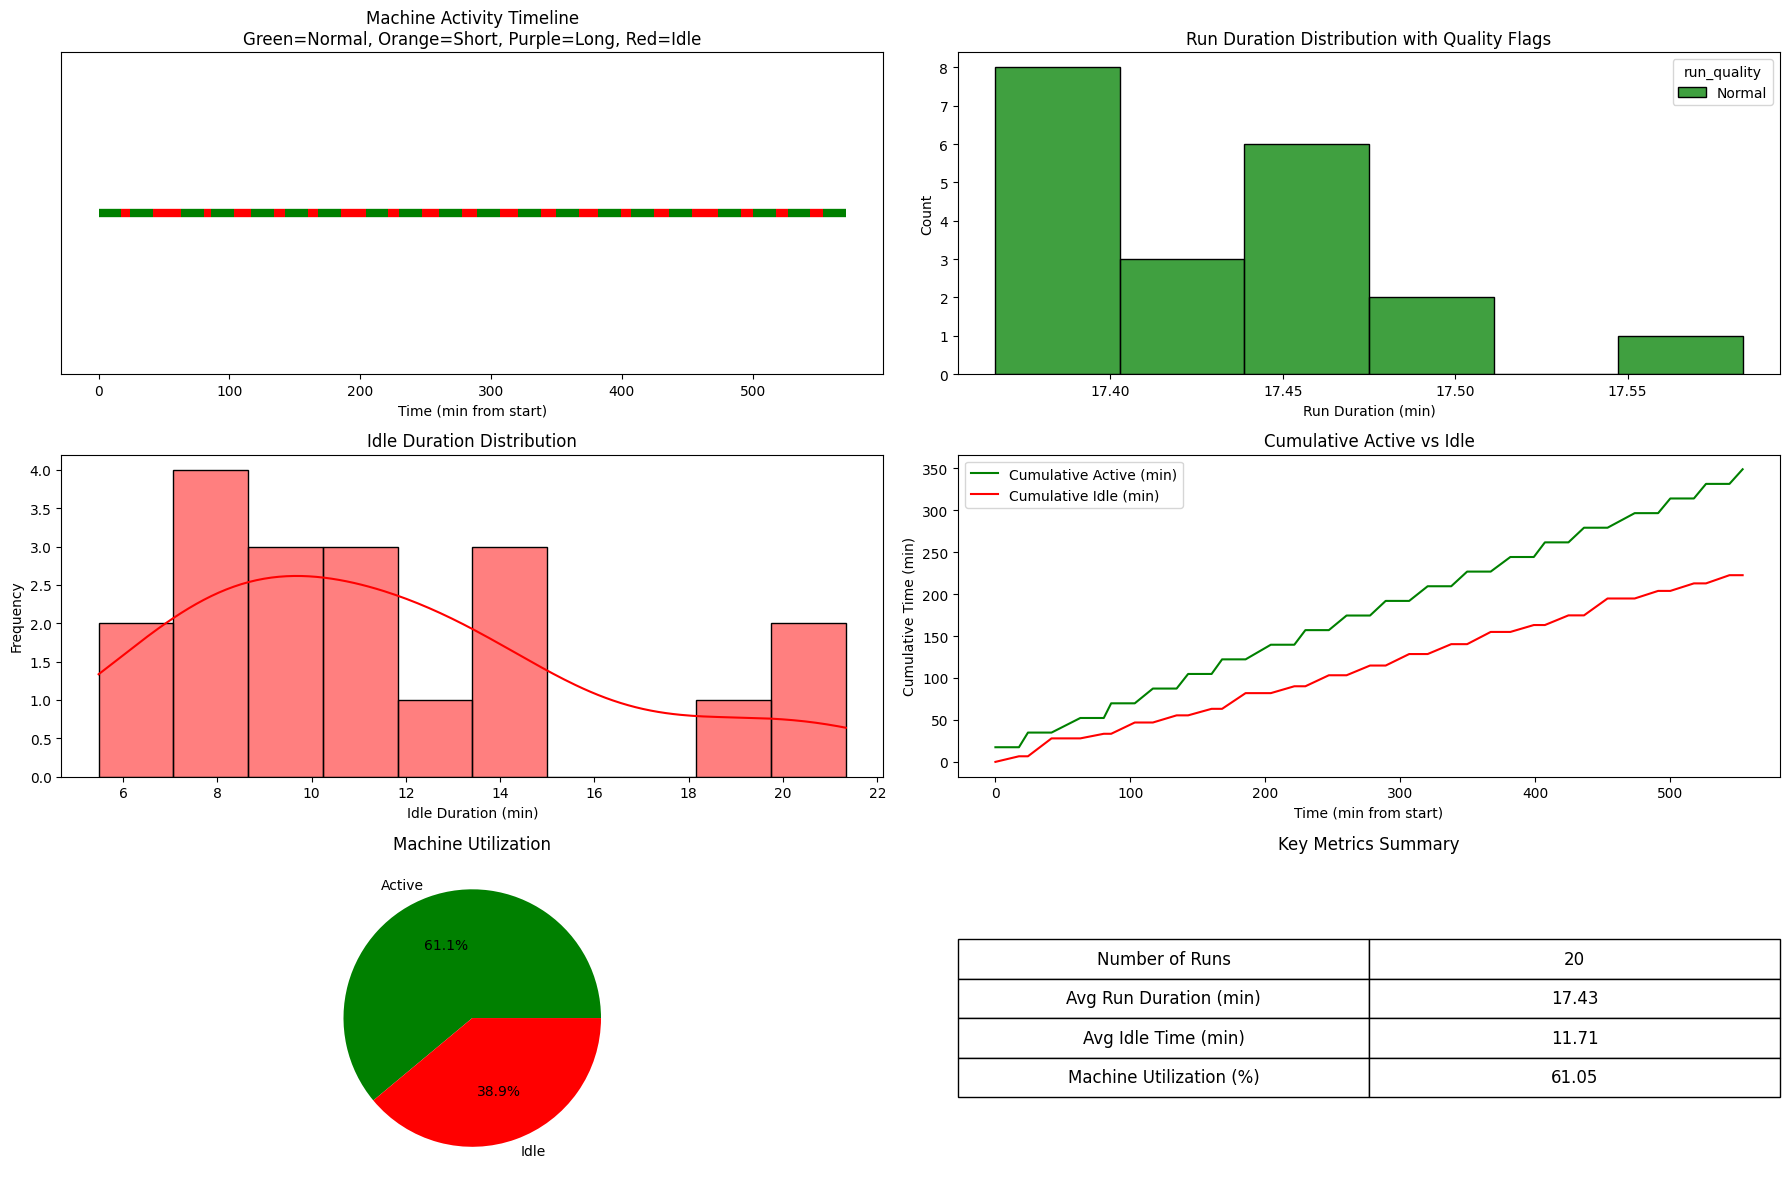

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from matplotlib.gridspec import GridSpec

# -------------------------------
# Step 1: Load database
# -------------------------------
DB_FILE = "machine_logs.db"
conn = sqlite3.connect(DB_FILE)
df = pd.read_sql_query("SELECT * FROM runs", conn)
conn.close()

# -------------------------------
# Step 2: Compute metrics and flags
# -------------------------------
avg_run_duration = df[df['status']=='ACTIVE']['duration_seconds'].mean()
threshold_short = avg_run_duration * 0.9
threshold_long = avg_run_duration * 1.1
df['run_quality'] = None
df.loc[(df['status']=='ACTIVE') & (df['duration_seconds'] < threshold_short), 'run_quality'] = 'Short'
df.loc[(df['status']=='ACTIVE') & (df['duration_seconds'] > threshold_long), 'run_quality'] = 'Long'
df.loc[(df['status']=='ACTIVE') & (df['duration_seconds'] >= threshold_short) &
       (df['duration_seconds'] <= threshold_long), 'run_quality'] = 'Normal'

total_active_time = df[df['status']=='ACTIVE']['duration_seconds'].sum()
total_idle_time = df[df['status']=='IDLE']['duration_seconds'].sum()
machine_utilization = total_active_time / (total_active_time + total_idle_time) * 100
num_runs = df[df['status']=='ACTIVE'].shape[0]
avg_idle_time = df[df['status']=='IDLE']['duration_seconds'].mean()
idle_df = df[df['status']=='IDLE']

# -------------------------------
# Step 3: Create storyboard figure
# -------------------------------
fig = plt.figure(figsize=(18,12))
gs = GridSpec(3,2, figure=fig)

# Timeline (Top-left)
ax0 = fig.add_subplot(gs[0,0])
for _, row in df.iterrows():
    color = 'red' if row['status']=='IDLE' else {'Normal':'green','Short':'orange','Long':'purple'}[row['run_quality']]
    ax0.hlines(1, row['start_offset_sec']/60, row['end_offset_sec']/60, colors=color, linewidth=6)
ax0.set_xlabel('Time (min from start)')
ax0.set_yticks([])
ax0.set_title('Machine Activity Timeline\nGreen=Normal, Orange=Short, Purple=Long, Red=Idle')

# Run duration histogram (Top-right)
ax1 = fig.add_subplot(gs[0,1])
sns.histplot(df[df['status']=='ACTIVE'], x=df['duration_seconds']/60, hue='run_quality', multiple='stack',
             palette={'Normal':'green','Short':'orange','Long':'purple'}, ax=ax1)
ax1.set_xlabel('Run Duration (min)')
ax1.set_ylabel('Count')
ax1.set_title('Run Duration Distribution with Quality Flags')

# Idle duration histogram (Middle-left)
ax2 = fig.add_subplot(gs[1,0])
sns.histplot(idle_df['duration_seconds']/60, bins=10, kde=True, color='red', ax=ax2)
ax2.set_xlabel('Idle Duration (min)')
ax2.set_ylabel('Frequency')
ax2.set_title('Idle Duration Distribution')

# Cumulative active vs idle (Middle-right)
df['cumulative_active_sec'] = df.apply(lambda r: r['duration_seconds'] if r['status']=='ACTIVE' else 0, axis=1).cumsum()
df['cumulative_idle_sec'] = df.apply(lambda r: r['duration_seconds'] if r['status']=='IDLE' else 0, axis=1).cumsum()
ax3 = fig.add_subplot(gs[1,1])
ax3.plot(df['start_offset_sec']/60, df['cumulative_active_sec']/60, label='Cumulative Active (min)', color='green')
ax3.plot(df['start_offset_sec']/60, df['cumulative_idle_sec']/60, label='Cumulative Idle (min)', color='red')
ax3.set_xlabel('Time (min from start)')
ax3.set_ylabel('Cumulative Time (min)')
ax3.set_title('Cumulative Active vs Idle')
ax3.legend()

# Pie chart utilization (Bottom-left)
ax4 = fig.add_subplot(gs[2,0])
ax4.pie([total_active_time, total_idle_time], labels=['Active','Idle'], colors=['green','red'], autopct='%1.1f%%')
ax4.set_title('Machine Utilization')

# Key metrics table (Bottom-right)
ax5 = fig.add_subplot(gs[2,1])
ax5.axis('off')
table_data = [
    ['Number of Runs', num_runs],
    ['Avg Run Duration (min)', round(avg_run_duration/60,2)],
    ['Avg Idle Time (min)', round(avg_idle_time/60,2)],
    ['Machine Utilization (%)', round(machine_utilization,2)]
]
table = ax5.table(cellText=table_data, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1,2)
ax5.set_title('Key Metrics Summary')

plt.tight_layout()

# -------------------------------
# Step 4: Save as high-res PNG
# -------------------------------
IMAGE_FILENAME = "Machine_Storyboard_HighRes.png"
fig.savefig(IMAGE_FILENAME, dpi=300, bbox_inches='tight')
print(f"High-resolution storyboard image saved as: {IMAGE_FILENAME}")

plt.show()
